In [1]:
import os, os.path
import numpy as np
import pandas as pd
import model_attributes as ma
from attribute_table import AttributeTable
import setup_analysis as sa
import support_functions as sf
import importlib
import itertools
import time
import warnings
import matplotlib.pyplot as plt
import model_afolu as mafl
import model_circular_economy as mc
import model_ippu as mi
import model_socioeconomic as ms
import scipy.optimize as sco 

importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(ms)

/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2635: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2392: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for desig, df in df_by_designation:
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2635: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector a

<module 'model_socioeconomic' from '/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_socioeconomic.py'>

In [2]:
#?sa.model_attributes.get_scalar
#            self.modvar_agrc_yf,
#            self.modvar_agrc_total_food_lost_in_ag,
#            "mass"
#        )
model_afolu = mafl.AFOLU(sa.model_attributes)
model_afolu.model_attributes.get_area_equivalent(
    model_afolu.modvar_lndu_ef_co2_conv,
    "mass"
)

In [7]:
#df_land_use["Item"].unique()
item = "Primary Forest"
item = "Naturally regenerating forest"
#item = "Planted Forest"
df_land_use[
    df_land_use["Area"].isin(["Mexico"])
    & df_land_use["Item"].isin([item])
    & df_land_use["Year"].isin([2015, 2016, 2017])
]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
98700,138,Mexico,6717,Naturally regenerating forest,5110,Area,2015,2015,1000 ha,66247.05,Q
98701,138,Mexico,6717,Naturally regenerating forest,5110,Area,2016,2016,1000 ha,66115.98,Q
98702,138,Mexico,6717,Naturally regenerating forest,5110,Area,2017,2017,1000 ha,65984.91,Q


In [5]:
#[x for x in df_land_use["Item"].unique() if "forest" in x.lower()]

In [8]:
df_land_use_emit[
    df_land_use_emit["Area"].isin(["Brazil"])
    #& df_land_use_emit["Item"].isin(["Forestland"])
    #& df_land_use_emit["Item"].isin(["Carbon stock change in forests"])
    & df_land_use_emit["Item"].isin(["Forestland"])
    #& df_land_use_emit["Item"].isin(["Net Forest conversion"])
    & df_land_use_emit["Year"].isin([2018, 2019, 2020])
    
]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Source Code,Source,Unit,Value,Flag,Note
4234,21,Brazil,6751,Forestland,5110,Area,2018,2018,3050,FAO TIER 1,1000 ha,499525.6800,E,NaN
4235,21,Brazil,6751,Forestland,5110,Area,2019,2019,3050,FAO TIER 1,1000 ha,498072.6400,E,NaN
4236,21,Brazil,6751,Forestland,5110,Area,2020,2020,3050,FAO TIER 1,1000 ha,496619.6000,E,NaN
4270,21,Brazil,6751,Forestland,72332,Net emissions/removals (CO2) (Forest land),2018,2018,3050,FAO TIER 1,kilotonnes,-269412.8448,Fc,NaN
4271,21,Brazil,6751,Forestland,72332,Net emissions/removals (CO2) (Forest land),2019,2019,3050,FAO TIER 1,kilotonnes,-269412.8448,Fc,NaN
4272,21,Brazil,6751,Forestland,72332,Net emissions/removals (CO2) (Forest land),2020,2020,3050,FAO TIER 1,kilotonnes,-269412.8448,Fc,NaN


In [6]:
# read in FAOSTAT DATA - note, the file encoding in encode is needed to read in FAOSTAT datasets
encode = "ISO-8859-1"

df_land_use = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Inputs_LandUse_E_All_Data_(Normalized)/Inputs_LandUse_E_All_Data_(Normalized).csv", encoding = encode)
df_land_cover = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Environment_LandCover_E_All_Data_(Normalized)/Environment_LandCover_E_All_Data_(Normalized).csv", encoding = encode)
df_land_use_emit = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Emissions_Land_Use_Forests_E_All_Data_(Normalized)/Emissions_Land_Use_Forests_E_All_Data_(Normalized).csv", encoding = encode)

# get base transition matrices from Costa Rica
df_base_transitions = pd.read_excel(
    "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/dev/fake_data/land_use_transition_baseline_assumption_fake_data.xlsx",
    sheet_name = "data_sheet"
)
df_base_transitions.sort_values(by = ["year", "scen", "cat"], inplace = True)
# categories in the transition dataset
cats_transition_template = [x for x in df_base_transitions.columns if (x not in ["year", "scen", "cat"])]
cats_transition_template.sort()
# transition matrices
array_base = np.array(df_base_transitions[df_base_transitions["scen"] == "bau"][cats_transition_template])
array_fut = np.array(df_base_transitions[df_base_transitions["scen"] == "ndp_nominal"][cats_transition_template])

In [9]:
df_land_use_emit_all = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Emissions_Totals_E_All_Data_(Normalized)/Emissions_Totals_E_All_Data_(Normalized).csv", encoding = encode)


/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/893732933.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_land_use_emit_all = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Emissions_Totals_E_All_Data_(Normalized)/Emissions_Totals_E_All_Data_(Normalized).csv", encoding = encode)


In [10]:
df_land_use_emit["Item"].unique()

#df_land_use_emit[
#    df_land_use_emit["Item"].isin(["Carbon stock change in forests"])
#]

array(['Forestland', 'Net Forest conversion',
       'Carbon stock change in forests'], dtype=object)

In [11]:

# renaming for 
dict_item_rnm_lu = {
    6620: "croplands",
    6717: "forests_primary",
    6716: "forests_secondary",
    6655: "grasslands",
    6670: "all_other"
}

dict_item_rnm_lc = {
    6970: "settlements",
    6975: "forests_mangroves",
    6976: "other",
    6977: "wetlands",
    6978: "other",
    6979: "other",
    6980: "other"
}

def get_areas_by_sisepuede_category(
    df_lc: pd.DataFrame,
    df_lu: pd.DataFrame,
    dict_item_rnm_lc: dict, 
    dict_item_rnm_lu: dict,
    country: str,
    year: int,
    cat_all_other: str = "all_other",
    element_keep: str = "Area",
    field_area: str = "Area",
    field_element: str = "Element",
    field_item_code: str = "Item Code",
    field_new_cat: str = "category",
    field_unit: str = "Unit",
    field_value: str = "Value", 
    field_year: str = "Year",
    unit_keep: str = "1000 ha"
) -> pd.DataFrame:
    
    fields_ext = [field_year, field_value, field_new_cat]
    
    dicts_out = {
        "lu": {"df": df_lu, "dict": dict_item_rnm_lu},
        "lc": {"df": df_lc, "dict": dict_item_rnm_lc}
    }
    # land use component
    for df_nm in ["lu", "lc"]:
        
        df = dicts_out[df_nm]["df"]
        dict_repl = dicts_out[df_nm]["dict"]
        
        df_merge = df[
            df[field_area].isin([country]) &
            df[field_unit].isin([unit_keep]) &
            df[field_year].isin([year])
        ]
        df_merge = df_merge[df_merge[field_item_code].isin(dict_repl.keys())]
        df_merge[field_new_cat] = np.array(df_merge[field_item_code].replace(dict_repl))
        df_merge.dropna(subset = [field_value], inplace = True)
        
        # aggregate by item code
        if df_nm == "lc":
            fields_grp = [field_year, field_new_cat, field_item_code]
            fields_agg = [field_value]
            dict_agg = dict(zip(fields_grp, ["first" for x in fields_grp]))
            dict_agg.update(dict(zip(fields_agg, ["mean" for x in fields_agg])))
            df_merge = df_merge.groupby(fields_grp).agg(dict_agg).reset_index(drop = True)
            
            # get sum
            fields_grp = [field_year, field_new_cat]
            fields_agg = [field_value]
            dict_agg = dict(zip(fields_grp, ["first" for x in fields_grp]))
            dict_agg.update(dict(zip(fields_agg, ["sum" for x in fields_agg])))
            df_merge.drop([field_item_code], axis = 1, inplace = True)
            df_merge = df_merge.groupby(fields_grp).agg(dict_agg).reset_index(drop = True)
            
        df_merge = df_merge[fields_ext].reset_index(drop = True)
        dicts_out[df_nm].update({"df_clean": df_merge})
    
    # some other cleaning
    df_lc = dicts_out["lc"]["df_clean"]
    df_lu = dicts_out["lu"]["df_clean"]
    field_tmp_cat = f"{field_new_cat}_new"
    # update lc
    total_lc = np.sum(np.array(df_lc[field_value]))
    frac_lc = np.array(df_lc[field_value])/total_lc
    df_lc["frac_cat"] = frac_lc
    df_lc[field_tmp_cat] = np.array(df_lc[field_new_cat])
    df_lc[field_new_cat] = cat_all_other
    df_lc.drop([field_value], axis = 1, inplace = True)
    
    # update lu
    df_lu["frac_cat"] = 1.0
    df_lu[field_tmp_cat] = np.array(df_lu[field_new_cat])
    
    df_lu_not_other = df_lu[df_lu[field_new_cat] != cat_all_other].copy()
    df_lu_other = df_lu[df_lu[field_new_cat] == cat_all_other].copy()
    df_lu_other = df_lu_other[[field_year, field_value, field_new_cat]]
    df_lu_other = pd.merge(df_lc, df_lu_other, how = "left")
    
    df_total_lu = pd.concat([df_lu_not_other, df_lu_other], axis = 0).reset_index(drop = True)
    
    df_total_lu["area"] = np.array(df_total_lu[field_value])*np.array(df_total_lu["frac_cat"])
    df_total_lu = df_total_lu[[field_year, field_tmp_cat, "area"]]
    df_total_lu.rename(columns = {field_year: "year", field_tmp_cat: "category"}, inplace = True)
    #return dicts_out["lc"]["df_clean"], dicts_out["lu"]["df_clean"]

    return df_total_lu

df_tmp = get_areas_by_sisepuede_category(
    df_land_cover, 
    df_land_use, 
    dict_item_rnm_lc,
    dict_item_rnm_lu,
    "Brazil", 2018
)


# specify FAOSTAT Land Cover and Land Use dataset, dictionary categories, country, and year to get data frame wide by year
def get_areas_by_sisepuede_category_wide_by_year(
    df_lc: pd.DataFrame,
    df_lu: pd.DataFrame,
    dict_item_rnm_lc: dict, 
    dict_item_rnm_lu: dict,
    country: str,
    years: list,
    **kwargs
):
    
    df_out = pd.DataFrame()
    for year in years:
        df_tmp = get_areas_by_sisepuede_category(
            df_lc, 
            df_lu, 
            dict_item_rnm_lc,
            dict_item_rnm_lu,
            country, year
        )
        
        df_tmp.rename(columns = {"area": f"year_{year}"}, inplace = True)
        df_tmp = df_tmp[[x for x in df_tmp.columns if (x != "year")]]
        df_out = df_tmp if (len(df_out) == 0) else pd.merge(df_out, df_tmp)
    
    df_out = df_out.sort_values(by = ["category"]).reset_index(drop = True)

    return df_out


"""
years_run = list(range(2000, 2019))
df_tmp = get_areas_by_sisepuede_category_wide_by_year(
    df_land_cover, 
    df_land_use, 
    dict_item_rnm_lc,
    dict_item_rnm_lu,
    "Guatemala",
    years_run
)

#df_tmp#[[x for x in df_tmp.columns if x != "category"]]#.sum(axis = 0)
nms = list(df_tmp["category"])
dict_rename = dict(zip(range(len(nms)), nms))
dict_rename.update({"index": "year"})
df_tmp2 = df_tmp.transpose().reset_index().rename(columns = dict_rename)
df_tmp2 = df_tmp2.iloc[1:]
df_tmp2["year"] = [int(x.replace("year_", "")) for x in list(df_tmp2["year"])]

fig, ax = plt.subplots(figsize = (15, 10))
df_tmp2.plot(x = "year", ax = ax)

""";


##  Work out a nonlinear, mimize error approach

In [116]:
df_areas
cats_transition_template
array_base_ones

# bound arrays

global_inf = 0.000001
global_sup = 1 - global_inf
diagonal_inf = 0.9875

array_ub = array_base_ones.copy()*global_sup
array_lb = array_base_ones.copy()*global_inf

# iterate from input constraints to format upper/lower bound matrices
bounds = dict_bounds_by_approach.get("max_diagonal").get("node_minima")
iters = itertools.product(range(array_base_ones.shape[0]), range(array_base_ones.shape[1]))

for k in iters:
    
    i, j = k
    inf_min = 0 if (i != j) else diagonal_inf
    
    if k in bounds.keys():
        bound, rel = bounds.get(k)
    elif i == j:
        bound = 0
        rel = ">"
    else:
        continue
    
    
    if rel in [">", "="]:
        array_lb[i, j] = max(bound, inf_min)
    elif rel in ["<", "="]:
        array_ub[i, j] = bound*int(array_ub[i, j] > 0)

        
# setup stp
x0 = np.array(df_areas["year_1999"])
x1 = np.array(df_areas["year_2000"])
n = len(df_areas)

def func_obj(
    vec_q: np.ndarray,
    n: int = n,
) -> float:
    """
    """
    q = vec_q.reshape((n, n))
    measure = ((x1 - np.dot(x0, q))**2).sum()**0.5
    
    return measure



##  BUILD CONSTRAINTS

dict_constraints = {}

# set bounds
bounds = zip(array_lb.flatten(), array_ub.flatten())
bounds = [tuple(x) for x in bounds]

# add summation to 1
A_1 = np.zeros((n, n**2))
for i in range(n):
    A_1[i, n*i:n*(i + 1)] = 1

dict_constraints.update(
    {
        "simplex": sco.LinearConstraint(A_1, lb = 1, ub = 1)
    }
)


x_est = sco.minimize(
    func_obj,
    array_lb.flatten(),
    bounds = bounds,
    constraints = [dict_constraints.get("simplex")],
)

/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [12]:
def format_transition_matrix_as_df(
    Q: np.ndarray, 
    cats: list
) -> pd.DataFrame:
    
    # build dataframe
    df_out = np.array([Q.flatten("C")])
    fields_out = [f"{x[0]}_to_{x[1]}" for x in itertools.product(cats, cats)]
    df_out = pd.DataFrame(df_out, columns = fields_out)
    
    return df_out



##  one approach -- use a linear program to get a palattable transition matrix
def solve_transition(
    v0: np.ndarray,
    v1: np.ndarray,
    array_template: np.ndarray, 
    cats: list,
    max_trans_prob: float = 0.999,
    min_trans_prob: float = 0.0001,
    dict_bound_by_node: dict = None,
    default_min: float = 0.96,
    optimization_approach: str = "min_diagonal",
    solver = "revised simplex"
) -> Tuple[np.ndarray]:
    """
    
    """
    inds = np.where(array_template > 0)
    row_inds, col_inds = inds

    ##  equality components

    # vector multiplication
    A_eq_p1 = np.zeros((len(v1), len(row_inds)))
    b_eq_p1 = v1
    
    # rows sum to 1
    A_eq_p2 = np.zeros((len(v0), len(row_inds)))
    b_eq_p2 = np.ones(len(v0))


    ##  inequality components

    # minimum values 
    A_leq_p1 = np.zeros((len(v0), len(row_inds)))
    b_leq_p1 = np.zeros(len(v0))
    dict_bounds = {} if (dict_bound_by_node is None) else dict_bound_by_node
    
    # get any non-diagonal elements
    nodes_non_diag = [k for k in dict_bounds.keys() if k[0] != k[1]]
    A_leq_p2 = np.zeros((len(nodes_non_diag), len(row_inds)))
    b_leq_p2 = np.zeros(len(nodes_non_diag))
    
    # initizlize objective
    c = np.zeros(len(row_inds))
    
    # loop over number of states to start with to set constraints on diagonal elements
    for i, const in enumerate(v0):
        
        for j in range(len(row_inds)):
            
            row = row_inds[j]
            col = col_inds[j]
            
            # matrix multiplication constraint
            A_eq_p1[i, j] = v0[row] if (col == i) else 0.0
            
            # row summation constraint
            A_eq_p2[i, j] = 1.0 if (row == i) else 0.0
            
            # add minimum values for diagonals only
            if (row == col) and (row == i):
                if ((row, col) in dict_bounds.keys()):
                    bound, orientation = dict_bounds[(row, col)]
                    # lower bound
                    if orientation == ">":
                        A_leq_p1[i, j] = -1 
                        b_leq_p1[i] = -bound
                    # upper bound
                    elif orientation == "<":
                        A_leq_p1[i, j] = 1 
                        b_leq_p1[i] = bound
                    
                else:
                    A_leq_p1[i, j] = -1 
                    b_leq_p1[i] = -default_min
                    
            # at first iteration, set objective function scalar
            if i == 0:
                if optimization_approach == "min_diagonal":
                    
                    # minimize the diagonal subject to some minimal values
                    c[j] = 1.0 if (row == col) else 0.0
                    
                elif optimization_approach == "max_diagonal":
                    
                    # maximize the diagonal subjecto to some minimal values elsewhere 
                    c[j] = -1.0 if (row == col) else 0.0
    
    nodes_non_diag_complete = [(-1, -1) for x in nodes_non_diag]
    
    # add any non-diagonal minimums
    for i, const in enumerate(nodes_non_diag):

        (row, col) = const
        j = np.where((row_inds == row) & (col_inds == col))

        if len(j) > 0:
            
            j = j[0]
            
            # add minimum values for non-diagonals
            bound, orientation = dict_bounds[(row, col)]
            
            if orientation == ">":
                # lower bound
                A_leq_p2[i, j] = -1 
                b_leq_p2[i] = -bound
            
            elif orientation == "<":
                # upper bound
                A_leq_p2[i, j] = 1 
                b_leq_p2[i] = bound

            nodes_non_diag_complete[i] = (row, col)
            
        else:
            print(f"row {row} and col {col} not found.\n")
   
                
    # setup matrices - leq and eq
    A_leq = np.concatenate([A_leq_p1, A_leq_p2])
    b_leq = np.concatenate([b_leq_p1, b_leq_p2])
    A_eq = np.concatenate([A_eq_p1, A_eq_p2])
    b_eq = np.concatenate([b_eq_p1, b_eq_p2])
    
    global c_out
    global A_leq_out
    global b_leq_out
    global A_eq_out
    global b_eq_out
    global vec_out
    
    c_out = c
    A_leq_out = A_leq
    b_leq_out = b_leq
    A_eq_out = A_eq
    b_eq_out = b_eq
    
    # get results
    vec = sco.linprog(
        c, A_leq, b_leq, A_eq, b_eq, 
        bounds = (min_trans_prob, max_trans_prob), 
        method = solver, 
        options = {
            "disp": False,
            "maxiter": 10000
        }
    )
    
    vec_out = vec

    # get transition matrix
    Q = np.zeros((len(v0), len(v0)))
    np.put(Q, inds[0]*len(v0) + inds[1], vec.x)
    
    # build dataframe
    df_out = format_transition_matrix_as_df(Q, cats)
    
    return Q, df_out, vec



def get_transition_component(
    df_areas_wide_by_year: pd.DataFrame,
    matrix_transition_template: np.ndarray,
    cats_ordered: list,
    field_category: str = "category",
    field_prepend_year: str = "year_",
    field_year: str = "year",
    solution_error_thresh: float = 0.000001,
    max_trans_prob: float = 0.998,
    min_trans_prob: float = 0.0001,
    dict_bound_by_node: dict = None, 
    dict_bound_by_node_2: dict = None,
    default_min: float = 0.96,
    optimization_approach: str = "min_diagonal",
    solver: str = "revised simplex"
):
    """
    
    """
    # initialize categories and available years
    cats_avail = list(df_areas_wide_by_year[field_category])
    years_avail_fields = [x for x in df_areas_wide_by_year.columns if (field_prepend_year in x)]
    years_avail = [int(x.replace(field_prepend_year, "")) for x in years_avail_fields]
    dict_ya_to_yaf = dict(zip(years_avail, years_avail_fields))
    dict_yaf_to_ya = dict(zip(years_avail_fields, years_avail))
    years_avail_sort = sorted(years_avail)
    # intialize
    ords = [cats_avail.index(cat) for cat in cats_ordered]
    df_areas = df_areas_wide_by_year.copy()
    df_areas = df_areas.loc[ords].reset_index(drop = True)
    
    # initialize outputs
    df_out = []
    Q_0 = 0.0
    count_Q = 0
    diagnostic_list = []
    
    min_error = 1
    min_error_df = None
    min_error_q = None
    min_error_y = None
    
    dict_design_choice = {}
    
    for ind in range(len(years_avail_sort) - 1):
        
        y0 = years_avail_sort[ind]
        y1 = years_avail_sort[ind + 1]
        y0_field = dict_ya_to_yaf[y0]
        y1_field = dict_ya_to_yaf[y1]

        v0 = np.array(df_areas[y0_field])
        v1 = np.array(df_areas[y1_field])
        
        # try a few orientations
        design_try = [
            # quality-ranked approaches, set by judgement
            (dict_bound_by_node, default_min, optimization_approach, max_trans_prob),
            (dict_bound_by_node, default_min, optimization_approach, 1),
            (dict_bound_by_node_2, default_min, optimization_approach, max_trans_prob),
            (dict_bound_by_node_2, default_min, optimization_approach, 1),
            ({}, default_min, optimization_approach, max_trans_prob),
            ({}, default_min, optimization_approach, 1),
            ({}, default_min**2, optimization_approach, max_trans_prob),
            ({}, default_min**2, optimization_approach, 1),
            ({}, default_min**3, optimization_approach, max_trans_prob),
            ({}, default_min**3, optimization_approach, 1),
            ({}, default_min**4, optimization_approach, max_trans_prob),
            ({}, default_min**4, optimization_approach, 1),
            ({}, default_min**5, optimization_approach, 1)
        ]
        
        i = 0
        dict_design_choice.update({y0: -1})
        error_val = solution_error_thresh*2 + 0.01
        Q = 0.0
        success = False
        
        # loop over design elements to try
        while (error_val > solution_error_thresh) and (i < len(design_try)) and not success:
            
            try:
                print(f"\tTrying design {i}...")
                Q, df_transitions, vec_sol = solve_transition(
                    v0, 
                    v1, 
                    matrix_transition_template, 
                    cats_ordered, 
                    max_trans_prob = design_try[i][3],
                    min_trans_prob = min_trans_prob,
                    dict_bound_by_node = design_try[i][0], 
                    default_min = design_try[i][1],
                    optimization_approach = design_try[i][2],
                    solver = solver
                )

                #dict_diag.update({ind: (A_eq_out, b_eq_out, c, vec_out)})
                success = vec_sol.success
                print(f"\tDesign {i} success status: {success}\n")
                
                # correct and normalize
                if success:
                    error_val = np.linalg.norm(np.dot(v0, Q) - v1)/np.linalg.norm(v1)
                    Q = sf.vec_bounds(Q, (0, 1)) if success else Q
                    Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose() if success else Q
                    
            except Exception as e:
                warnings.warn(f"Warning: solution infeasible. Resetting error {e}")
                error_val = solution_error_thresh*2 + 0.01
            
            i += 1
        
        # some updates to find best year in case nothing is used
        diagnostic_list.append((y0, i - 1))
        
        fail_q = True
        if np.sum(Q) > 0:
            if ind == 0:
                min_error = error_val
                min_error_q, min_error_df, min_error_y = Q, df_transitions, y0
            elif error_val < min_error:
                min_error = error_val
                min_error_q, min_error_df, min_error_y = Q, df_transitions, y0
        
            # add to output mean 
            if (error_val <= solution_error_thresh):
                fail_q = False
                print(f"In year {y0}, found acceptable solution on design {i - 1}.\n")
                dict_design_choice.update({y0: i - 1})
                Q_0 += Q
                count_Q += 1
                df_transitions[field_year] = y0
                df_out.append(df_transitions)

        print(f"Year {y0} failed.\n") if fail_q else None
    
    # if no options were selected
    if (len(df_out) == 0):
        Q_0 = min_error_q
        count_Q = 1
        df_transitions = min_error_df
        if (df_transitions is not None):
            df_transitions[field_year] = min_error_y

        df_out.append(df_transitions)
        print(f"\tNo options found. Assigning best fit from year {min_error_y} with error {min_error}\n\n")
            
    # update mean
    if (count_Q > 0) and (df_transitions is not None):
        Q_0 = Q_0/count_Q if (count_Q > 0) else Q_0
        df_mean = format_transition_matrix_as_df(Q_0, cats_ordered)
        df_out = pd.concat(df_out, axis = 0)
    
        return df_out, df_mean, diagnostic_list, dict_design_choice
    else:
        return None, None, diagnostic_list, dict_design_choice

"""
df_out, df_mean, diagnostic_list = get_transition_component(
    df_tmp,
    array_base,#np.ones(array_base.shape),
    cats_transition_template,
    min_trans_prob = 0.0,
    dict_bound_by_node = {
        (0, 5): (0.01, "<"),
        # forest mangroves to forest mangroves
        (1, 1): (0.9, ">"),
        # primary forests to cropland
        (2, 0): (0.0002, ">"),
         # primary forests to primary forests
        (2, 2): (0.98, ">"),
        # primary forests to secondary forests
        (2, 3): (0.00005, "<"),
        # secondary forests to secondary forests
        #(3, 3): 0.9,
        # other lands
        (5, 5): (0.8, ">"),
        # settlements to settlements
        (6, 6): (0.99, ">")

    },
    optimization_approach = "max_diagonal",
    default_min = 0.96
    
)""";


In [21]:
df_areas

,category,year_1999,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,...,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,croplands,1270.000000,1318.000000,1318.000000,1318.000000,1238.000000,1220.000000,1220.000000,1220.000000,1220.000000,...,1200.000000,1200.000000,1200.000000,1155.000000,1155.000000,1155.000000,1232.000000,1232.000000,1232.000000,1232.000000
1,forests_mangroves,17.017162,13.799859,17.280936,16.985630,20.963569,21.963369,21.642898,21.123943,20.554534,...,21.049122,20.414532,20.036328,22.199426,21.607598,20.999151,16.338476,16.058171,15.514542,15.247252
2,forests_primary,1893.875000,1929.430000,1932.768000,1936.106000,1939.444000,1942.782000,1946.120000,1949.458000,1952.796000,...,1959.472000,1962.810000,1964.202800,1965.595700,1966.988500,1968.381400,1969.774200,1953.610000,1953.730000,1953.850000
3,forests_secondary,40.846000,43.050000,49.775000,56.500000,63.225000,69.950000,76.675000,83.400000,90.125000,...,103.575000,110.300000,115.016000,119.732000,124.448000,129.164000,133.880000,158.130000,166.100000,174.070000
4,grasslands,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,...,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
5,other,193.014620,152.300054,125.677346,120.712230,144.356870,144.165203,139.360865,135.026590,129.841091,...,127.303321,123.658504,121.843300,135.443288,133.776770,132.249323,103.428525,101.587999,98.310167,95.771431
6,settlements,30.679564,25.514661,63.657278,62.927183,77.983309,80.929474,79.874845,78.588862,77.547008,...,79.846002,78.199922,77.336311,86.753063,86.675766,86.564755,68.248810,66.349967,64.951202,63.447851
7,wetlands,188.576654,151.915426,126.849440,122.774957,150.031252,154.211954,150.326392,146.400605,143.132367,...,142.746556,138.607042,135.558060,149.272224,145.501865,141.642771,110.334189,106.263863,103.394089,99.613466


In [44]:
# set up allowable transition classes
w = np.where(array_base != 0)
array_base_ones = np.zeros(array_base.shape)
np.put(array_base_ones, w[0]*(len(array_base_ones))+w[1], 1)


# setup run over all countries
attr_region = sa.model_attributes.get_other_attribute_table(sa.model_attributes.dim_region)
all_countries = set(attr_region.table["category_name"])
countries = set(df_land_cover["Area"]) & set(df_land_use["Area"]) & all_countries
countries = countries | set({"Bolivia (Plurinational State of)", "Venezuela (Bolivarian Republic of)"})

countries = ["Dominican Republic"]
# get 20 years of data
years_run = list(range(1999, 2019))

# initialize output
df_all_transitions_out = []
df_mean_transition_out = []

# functio to reformat the country name for integration
def format_country_name(country: str) -> str:
    country_out = country.split("(")[0].strip().lower().replace(" ", "_")
    return country_out

            

# specify different minimum values by approach t
dict_bounds_by_approach = {
    "min_diagonal": {
        "node_minima": {
            # cropland to grassland
            (0, 4): (0.0001, ">"),
            # cropland to other
            (0, 5): (0.005, "<"),
           
            # forest mangroves to forest mangroves
            (1, 1): (0.97, ">"),

            # primary forests to primary forests
            (2, 2): (0.99, ">"),
            
            
            # grasslands to other
            (4, 5): (0.0005, "<"),
            
            # other lands
            (5, 5): (0.8, ">"),
            
            # settlements to other
            (6, 5): (0.0001, "<"),
            # settlements to settlements
            (6, 6): (0.99, ">"),
            
            # wetlands to grasslands
            (7, 4): (0.0005, "<"),
            # wetlands to other
            (7, 5): (0.0001, "<"),
            # wetlands to wetlands
            (7, 7): (0.98, ">")
            
        },
        "default_min_diagonal": 0.95,
        "max_pij": 0.9985,
        "min_pij": 0.0
    },
    
    "max_diagonal": {
        "node_minima": {
            # cropland to cropland
            #(0, 0): (0.995, "<"),
            (0, 0): (0.995, ">"),
            # cropland to forests_secondary
            (0, 3): (0.0005, ">"),
            # cropland to grassland
            #(0, 4): (0.0001, ">"),
            # cropland to other
            #(0, 5): (0.001, "<"),
            
            # forests_mangroves to other
            (1, 5): (0.00001, "<"),
            
            # primary forests to cropland
            #(2, 0): (0.000, ">"),
            # primary forests to primary forests
            (2, 2): (0.99, ">"),
            
            # secondary forests to primary forests
            (3, 2): (0.02, "<"),
            
            # grasslands to grasslands
            (4, 4): (0.98, ">"),
            # grasslands to other
            (4, 5): (0.0005, "<"),
            
            # other may be too stagnant--place max on other_to_other
            (5, 5): (0.99, ">"),
            
            # settlements to other
            (6, 5): (0.0001, "<"),
            # settlements to settlements
            (6, 6): (0.995, ">"),
            
            # wetlands to grasslands
            (7, 4): (0.0005, "<"),
            # wetlands to other
            (7, 5): (0.0001, "<"),
            # wetlands to wetlands
            (7, 7): (0.98, ">"),
            
            
        },
        "default_min_diagonal": 0.98,
        "max_pij": 0.999,
        "min_pij": 0.0
    }
}

nodes_del_for_2 = [list(dict_bounds_by_approach[x].get("node_minima").keys()) for x in dict_bounds_by_approach.keys()]
nodes_del_for_2 = list(set(sum(nodes_del_for_2, [])))
nodes_del_for_2 = [x for x in nodes_del_for_2 if (x[0] != x[1])] + [(3, 2), (3, 4), (3, 5)]

dict_bounds_by_country = {}
dict_bounds_by_country_2 = {}

for country in countries:
    
    dict_cur = {}
    for k in dict_bounds_by_approach.keys():
        val = dict_bounds_by_approach.get(k)
        dict_cur.update({k: val})
        
    # add some generalized constraints
    dict_update = {
        # forests_secondary to forests_primary
        (3, 2): (0.0005, "<"),
        # forests_secondary to grasslands
        (3, 4): (0.001, "<"),
        # forests_secondary to other
        (3, 5): (0.0001, "<")
    }
    
    #
    for i in range(8):
        # some wetlands caps
        if i != 7:
            dict_update.update({(i, 7): (0.01, "<")})
    
            
    # add some country-specific modifications
    if country == "Argentina":
        # loosen the croplands and grasslands to other constraints
        dict_update.update({
            (0, 5): (0.005, "<"),
            (4, 5): (0.005, "<")
        })
    elif country == "Brazil":
        dict_update.update({
            # croplands to forest_mangroves
            (0, 1): (0.00075, "<"),
            # primary forests to cropland
            (2, 0): (0.00075, ">"),
            # primary forests to grassland
            (2, 4): (0.003, ">"),
            # primary forests to other
            (2, 5): (0.0001, "<"),
            # grassland to secondary forest
            (4, 3): (0.01, "<")
            
        })
        
    elif country == "Guatemala":
        
        # loosen the croplands and grasslands to other constraints
        dict_update.update({
            (0, 5): (0.01, "<"),
            (4, 5): (0.01, "<"),
            (2, 2): (0.95, ">"),
            (2, 5): (0.005, "<")
        })
        

        for tp in ["min_diagonal", "max_diagonal"]:
            for key in [(0, 3), (5, 5)]:
                try:
                    dict_cur[tp]["node_minima"].pop(key)
                except:
                    None
        
        
    for tp in ["min_diagonal", "max_diagonal"]:
        dict_cur[tp]["node_minima"].update(dict_update)
        #dict_cur[tp]["node_minima"] = {}#dict_update
        
        
    dict_cur_2 = {}
    for tp in ["min_diagonal", "max_diagonal"]:
        val = dict_cur.get(tp)
        dict_cur_2.update({tp: {}})
        for kv in val.keys():
            val_mid = val.get(kv)
            dict_cur_2[tp].update({kv: val_mid}) if not isinstance(val_mid, dict) else None
            if isinstance(val_mid, dict):
                dict_cur_2[tp].update({kv: {}})
                for kv_2 in val.get(kv).keys():
                    val_2 = val.get(kv).get(kv_2)
                    dict_cur_2[tp][kv].update({kv_2: val_2}) if (kv_2[0] == kv_2[1]) else dict_cur_2[tp][kv].update({kv_2: (0.0075, "<")})

    ##  DO POPS

    dict_bounds_by_country.update({country: dict_cur})
    dict_bounds_by_country_2.update({country: dict_cur_2})

    
    
    
    
"""
croplands:	0
forests_mangroves:	1
forests_primary:	2
forests_secondary:	3
grasslands:	4
other:	5
settlements:	6
wetlands:	7
"""

header = "#"*40
#for country in enumerate(["Argentina", "Bolivia (Plurinational State of)"]):
countries = sorted(list(countries))#["Brazil", "Guatemala"]#

for country in enumerate(countries):

    ind, country = country
    
    print(f"{header}\n##\n##\tStarting country {country}\n##\n{header}\n")
    # get areas
    df_areas = get_areas_by_sisepuede_category_wide_by_year(
        df_land_cover, 
        df_land_use, 
        dict_item_rnm_lc,
        dict_item_rnm_lu,
        country,
        years_run
    )
    
    dict_bounds_by_approach_country = dict_bounds_by_country.get(country)
    dict_bounds_by_approach_country_2 = dict_bounds_by_country_2.get(country)
    
    for optimization_bound in dict_bounds_by_approach.keys():
        
        dict_node_minima = dict_bounds_by_approach_country[optimization_bound]["node_minima"]
        dict_node_minima_2 = dict_bounds_by_approach_country_2[optimization_bound]["node_minima"]
        default_min_diagonal = dict_bounds_by_approach_country[optimization_bound]["default_min_diagonal"]
        max_pij = dict_bounds_by_approach_country[optimization_bound]["max_pij"]
        min_pij = dict_bounds_by_approach_country[optimization_bound]["min_pij"]
        
        # get transitions
        try: 
            df_all_transitions, df_mean_transition, diagnostic_list, dict_design_choice = get_transition_component(
                df_areas,
                array_base_ones,
                cats_transition_template,
                dict_bound_by_node = dict_node_minima,
                dict_bound_by_node_2 = dict_node_minima_2,
                solution_error_thresh = 0.001,
                default_min = default_min_diagonal,
                optimization_approach = optimization_bound,
                max_trans_prob = max_pij,
                min_trans_prob = min_pij,
                solver = "revised simplex"
            )
            
            
        except:
            df_all_transitions, df_mean_transition, diagnostic_list, dict_design_choice = get_transition_component(
                df_areas,
                array_base_ones,
                cats_transition_template,
                dict_bound_by_node = dict_node_minima,
                dict_bound_by_node_2 = dict_node_minima_2,
                solution_error_thresh = 0.001,
                default_min = default_min_diagonal,
                optimization_approach = optimization_bound,
                max_trans_prob = 1,
                min_trans_prob = min_pij,
                solver = "revised simplex"
            )
    
        country_out = format_country_name(country)

        if df_all_transitions is not None:
            df_all_transitions["country"] = country_out
            df_all_transitions["optimization_bound"] = optimization_bound
            df_mean_transition["country"] = country_out
            df_mean_transition["optimization_bound"] = optimization_bound
            df_all_transitions["design_quality_rank"] = np.array(df_all_transitions["year"].replace(dict_design_choice)) + 1

            # add all transitions to output
            if len(df_all_transitions_out) == 0:
                df_all_transitions_out.append(df_all_transitions)
            else:
                df_all_transitions_out.append(df_all_transitions[df_all_transitions_out[0].columns])
            # add only mean to output
            if len(df_mean_transition_out) == 0:
                df_mean_transition_out.append(df_mean_transition)
            else:
                df_mean_transition_out.append(df_mean_transition[df_mean_transition_out[0].columns])

            print(f"Country {country} complete with {len(df_all_transitions)} found.")
        else:
            warnings.warn(f"Country {country} incomplete with no data.")

df_all_transitions_out = pd.concat(df_all_transitions_out, axis = 0).sort_values(by = ["optimization_bound", "country", "year"]).reset_index(drop = True) if (len(df_all_transitions_out) > 0) else None
df_mean_transition_out = pd.concat(df_mean_transition_out, axis = 0).sort_values(by = ["optimization_bound", "country"]).reset_index(drop = True) if (len(df_mean_transition_out) > 0) else None





if df_all_transitions_out is not None:
    ##  generate mean based on most recent years

    num_years_mean_max = 4
    df_max_times = df_all_transitions_out[["country", "year"]].groupby(["country"]).agg({"year": "max", "country": "first"}).reset_index(drop = True)

    ##  get most recent years
    df_merge_keep_years = []
    for country in df_max_times["country"].unique():
        m1 = int(df_max_times[df_max_times["country"] == country]["year"])
        df_component = pd.DataFrame({"country": country, "year": np.arange(m1 - num_years_mean_max + 1, m1 + 1).astype(int) })
        df_merge_keep_years.append(df_component)
    df_merge_keep_years = pd.concat(df_merge_keep_years, axis = 0).reset_index(drop = True)


    ##  initialize output df and build aggregation dictionary
    df_mean_transitions_out_from_recent = pd.merge(df_all_transitions_out, df_merge_keep_years, how = "inner")
    fields_grp = ["country", "optimization_bound"]
    fields_data = [x for x in df_mean_transitions_out_from_recent.columns if (x not in fields_grp + ["year"])]
    dict_agg = dict(zip(fields_grp, ["first" for x in fields_grp]))
    dict_agg.update(dict(zip(fields_data, ["mean" for x in fields_data])))

    ##  aggregate to means
    df_mean_transitions_out_from_recent = df_mean_transitions_out_from_recent[dict_agg.keys()].groupby(fields_grp).agg(dict_agg).reset_index(drop = True)




    if False:
        df_all_transitions_out.to_csv(sa.fp_csv_transition_probability_estimation_annual, index = None, encoding = "UTF-8")
        df_mean_transition_out.to_csv(sa.fp_csv_transition_probability_estimation_mean, index = None, encoding = "UTF-8")
        df_mean_transitions_out_from_recent.to_csv(sa.fp_csv_transition_probability_estimation_mean_recent, index = None, encoding = "UTF-8")





########################################
##
##	Starting country Dominican Republic
##
########################################

	Trying design 0...
	Design 0 success status: False

	Trying design 1...
	Design 1 success status: False

	Trying design 2...
	Design 2 success status: False

	Trying design 3...
	Design 3 success status: False

	Trying design 4...
	Design 4 success status: False

	Trying design 5...
	Design 5 success status: False

	Trying design 6...
	Design 6 success status: False

	Trying design 7...
	Design 7 success status: False

	Trying design 8...
	Design 8 success status: False

	Trying design 9...
	Design 9 success status: False

	Trying design 10...
	Design 10 success status: False

	Trying design 11...
	Design 11 success status: False

	Trying design 12...
	Design 12 success status: False

Year 1999 failed.

	Trying design 0...
	Design 0 success status: False

	Trying design 1...
	Design 1 success status: False

	Trying design 2...
	Design 2 success status: False


/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem for

	Design 9 success status: False

	Trying design 10...
	Design 10 success status: False

	Trying design 11...
	Design 11 success status: False

	Trying design 12...
	Design 12 success status: False

Year 2008 failed.

	Trying design 0...
	Design 0 success status: False

	Trying design 1...
	Design 1 success status: False

	Trying design 2...
	Design 2 success status: False

	Trying design 3...
	Design 3 success status: False

	Trying design 4...
	Design 4 success status: False

	Trying design 5...
	Design 5 success status: False

	Trying design 6...
	Design 6 success status: False

	Trying design 7...
	Design 7 success status: False

	Trying design 8...
	Design 8 success status: False

	Trying design 9...
	Design 9 success status: False

	Trying design 10...
	Design 10 success status: False

	Trying design 11...
	Design 11 success status: False

	Trying design 12...
	Design 12 success status: False

Year 2009 failed.

	Trying design 0...
	Design 0 success status: False

	Trying design 1

/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem for

	Design 2 success status: False

	Trying design 3...
	Design 3 success status: False

	Trying design 4...
	Design 4 success status: True

In year 2017, found acceptable solution on design 4.

Country Dominican Republic complete with 2 found.
	Trying design 0...
	Design 0 success status: False

	Trying design 1...
	Design 1 success status: False

	Trying design 2...
	Design 2 success status: False

	Trying design 3...
	Design 3 success status: False

	Trying design 4...
	Design 4 success status: False

	Trying design 5...
	Design 5 success status: False

	Trying design 6...
	Design 6 success status: False

	Trying design 7...
	Design 7 success status: False

	Trying design 8...
	Design 8 success status: False

	Trying design 9...
	Design 9 success status: False

	Trying design 10...
	Design 10 success status: False

	Trying design 11...
	Design 11 success status: False

	Trying design 12...
	Design 12 success status: False

Year 1999 failed.

	Trying design 0...
	Design 0 success status

/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem for

	Design 11 success status: False

	Trying design 12...
	Design 12 success status: False

Year 2010 failed.

	Trying design 0...
	Design 0 success status: False

	Trying design 1...
	Design 1 success status: False

	Trying design 2...
	Design 2 success status: False

	Trying design 3...
	Design 3 success status: False

	Trying design 4...
	Design 4 success status: False

	Trying design 5...
	Design 5 success status: False

	Trying design 6...
	Design 6 success status: False

	Trying design 7...
	Design 7 success status: False

	Trying design 8...
	Design 8 success status: False

	Trying design 9...
	Design 9 success status: False

	Trying design 10...
	Design 10 success status: False

	Trying design 11...
	Design 11 success status: False

	Trying design 12...
	Design 12 success status: False

Year 2011 failed.

	Trying design 0...
	Design 0 success status: False

	Trying design 1...
	Design 1 success status: False

	Trying design 2...
	Design 2 success status: False

	Trying design 3...

/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  vec = sco.linprog(
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_39655/1019496287.py:141: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem for

In [45]:
vec = df_all_transitions_out.iloc[0]

for k in vec.index:
    print(f"{k}:\t{vec.get(k)}")

croplands_to_croplands:	0.9989446115946939
croplands_to_forests_mangroves:	0.0
croplands_to_forests_primary:	0.0
croplands_to_forests_secondary:	0.0010553884053061155
croplands_to_grasslands:	0.0
croplands_to_other:	0.0
croplands_to_settlements:	0.0
croplands_to_wetlands:	0.0
forests_mangroves_to_croplands:	0.03385370145600283
forests_mangroves_to_forests_mangroves:	0.9661462985439971
forests_mangroves_to_forests_primary:	0.0
forests_mangroves_to_forests_secondary:	0.0
forests_mangroves_to_grasslands:	0.0
forests_mangroves_to_other:	0.0
forests_mangroves_to_settlements:	0.0
forests_mangroves_to_wetlands:	0.0
forests_primary_to_croplands:	0.0003872881486069773
forests_primary_to_forests_mangroves:	0.0
forests_primary_to_forests_primary:	0.999
forests_primary_to_forests_secondary:	0.0
forests_primary_to_grasslands:	0.0006127118513930236
forests_primary_to_other:	0.0
forests_primary_to_settlements:	0.0
forests_primary_to_wetlands:	0.0
forests_secondary_to_croplands:	0.0
forests_secondary_

In [435]:
=

SyntaxError: invalid syntax (<ipython-input-435-9ae22869553b>, line 1)

In [445]:
for cat in sa.model_attributes.get_attribute_table("Land Use").key_values:
    flds = [x for x in df_all.columns if x.startswith(f"{cat}_to_")]
    flds_diag = [f"{cat}_to_{cat}"]
    flds_offdiag = [x for x in flds if x not in flds_diag]
    
    #df_all = df_all_transitions_out[df_all_transitions_out["country"].isin(["chile"])].copy()
    df_all = df_all_transitions_out[
        df_all_transitions_out["optimization_bound"].isin(["max_diagonal"]) &
        df_all_transitions_out["country"].isin(["brazil", "peru", "chile", "mexico", "argentina"])
    ].copy()
    df_all["sum_other"] = df_all[flds].sum(axis = 1)
    df_all[df_all["sum_other"] > 0.999][flds + ["sum_other", "year", "optimization_bound"]]
    #df_all.iloc[646]
    
    max_diag = np.round(np.max(np.array(df_all[flds_diag])), 5)
    max_offdiag = np.round(np.max(np.array(df_all[flds_offdiag])), 5)
    min_diag = np.round(np.min(np.array(df_all[flds_diag])), 5)
    min_offdiag = np.round(np.min(np.array(df_all[flds_offdiag])), 5)

    maxerr = np.max(np.abs(np.array(df_all["sum_other"]) - 1))
    
    print(f"Max error for cat {cat}:\t{maxerr}\n\tMin/Max diag:\t{min_diag}, {max_diag}\n\tMin/Max off-diag:\t{min_offdiag}, {max_offdiag}")
    

Max error for cat croplands:	4.6948356269282954e-07
	Min/Max diag:	0.9322, 1.0
	Min/Max off-diag:	-0.0, 0.04353
Max error for cat forests_mangroves:	1.1102230246251565e-16
	Min/Max diag:	0.86538, 1.0
	Min/Max off-diag:	-0.0, 0.13462
Max error for cat forests_primary:	2.220446049250313e-16
	Min/Max diag:	0.98884, 1.0
	Min/Max off-diag:	-0.0, 0.01103
Max error for cat forests_secondary:	1.1102230246251565e-16
	Min/Max diag:	0.94141, 1.0
	Min/Max off-diag:	-0.0, 0.05859
Max error for cat grasslands:	1.1102230246251565e-16
	Min/Max diag:	0.97614, 1.0
	Min/Max off-diag:	-0.0, 0.02386
Max error for cat other:	1.1102230246251565e-16
	Min/Max diag:	0.98265, 1.0
	Min/Max off-diag:	-0.0, 0.01471
Max error for cat settlements:	0.0
	Min/Max diag:	0.98203, 1.0
	Min/Max off-diag:	-0.0, 0.01797
Max error for cat wetlands:	0.0
	Min/Max diag:	0.91404, 1.0
	Min/Max off-diag:	-0.0, 0.08596


In [88]:
df_all_transitions_out[[x for x in df_all_transitions_out if x.startswith("other_to_")]].sum(axis = 1)
#[x for x in df_all_transitions_out if x.startswith("other_to_")]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
744    1.0
745    1.0
746    1.0
747    1.0
748    1.0
Length: 749, dtype: float64

In [ ]:
x

In [44]:
df_mean_transition_out[df_mean_transition_out["country"] == "brazil"][
    [x for x in df_mean_transition_out.columns if ("forests_primary_to" in x)]
]#.iloc[0

,forests_primary_to_croplands,forests_primary_to_forests_mangroves,forests_primary_to_forests_primary,forests_primary_to_forests_secondary,forests_primary_to_grasslands,forests_primary_to_other,forests_primary_to_settlements,forests_primary_to_wetlands


In [176]:
df_mean_transition_out[df_mean_transition_out["country"] == "brazil"][
    [x for x in df_mean_transition_out.columns if ("to_wetlands" in x)]
]#.iloc[0]

,croplands_to_wetlands,forests_mangroves_to_wetlands,forests_primary_to_wetlands,forests_secondary_to_wetlands,grasslands_to_wetlands,other_to_wetlands,settlements_to_wetlands,wetlands_to_wetlands
0,0.000946,0.0,0.000579,0.0,0.000716,0.000433,0.000521,0.96
1,0.000531,0.0,0.000509,0.0,0.000476,0.000000,0.000000,0.98


In [151]:
df_all_transitions_out.to_csv(sa.fp_csv_transition_probability_estimation_annual, index = None, encoding = "UTF-8")
df_mean_transition_out.to_csv(sa.fp_csv_transition_probability_estimation_mean, index = None, encoding = "UTF-8")

In [472]:
sa.fp_csv_transition_probability_estimation_mean

'/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/baseline_transition_probability_estimates/transition_probs_by_region_mean.csv'

,country,optimization_bound,croplands_to_croplands,croplands_to_forests_mangroves,croplands_to_forests_primary,croplands_to_forests_secondary,croplands_to_grasslands,croplands_to_other,croplands_to_settlements,croplands_to_wetlands,...,settlements_to_settlements,settlements_to_wetlands,wetlands_to_croplands,wetlands_to_forests_mangroves,wetlands_to_forests_primary,wetlands_to_forests_secondary,wetlands_to_grasslands,wetlands_to_other,wetlands_to_settlements,wetlands_to_wetlands
0,brazil,max_diagonal,0.994321,0.000188,0.0,0.001225,0.000100,0.0037,0.0,0.000466,...,0.9985,0.0,0.0011,0.000375,0.0,0.0,0.0000,0.000025,0.0,0.9985
1,brazil,min_diagonal,0.950000,0.000000,0.0,0.000000,0.045000,0.0050,0.0,0.000000,...,0.9800,0.0,0.0194,0.000000,0.0,0.0,0.0005,0.000100,0.0,0.9800
2,guatemala,max_diagonal,0.991220,0.000750,0.0,0.000000,0.000100,0.0050,0.0,0.000000,...,0.9900,0.0,0.0399,0.000000,0.0,0.0,0.0000,0.000100,0.0,0.9600
3,guatemala,min_diagonal,0.950000,0.000750,0.0,0.001590,0.041614,0.0050,0.0,0.000000,...,0.9800,0.0,0.0199,0.000000,0.0,0.0,0.0000,0.000100,0.0,0.9800


In [2]:
sa.fp_csv_transition_probability_estimation_mean_recent

'/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/batch_data_generation/baseline_transition_probability_estimates/transition_probs_by_region_mean_recent_only.csv'

In [61]:
dict_agg

{'country': 'mean', 'optimization_bound': 'mean'}

,country,optimization_bound,croplands_to_croplands,croplands_to_forests_mangroves,croplands_to_forests_primary,croplands_to_forests_secondary,croplands_to_grasslands,croplands_to_other,croplands_to_settlements,croplands_to_wetlands,...,settlements_to_settlements,settlements_to_wetlands,wetlands_to_croplands,wetlands_to_forests_mangroves,wetlands_to_forests_primary,wetlands_to_forests_secondary,wetlands_to_grasslands,wetlands_to_other,wetlands_to_settlements,wetlands_to_wetlands
0,argentina,max_diagonal,0.927751,0.000000,0.0,0.000000,0.000100,0.005000,0.000000,0.000106,...,0.990000,0.002475,0.030275,0.000000,0.0,0.000000,0.000000,0.000100,0.000000,0.969625
1,argentina,min_diagonal,0.950000,0.000000,0.0,0.000000,0.000100,0.005000,0.000000,0.000000,...,0.980000,0.005000,0.010900,0.000000,0.0,0.000000,0.000000,0.000100,0.000000,0.989000
2,bahamas,max_diagonal,0.988292,0.000375,0.0,0.000000,0.000100,0.003750,0.004983,0.002500,...,0.990000,0.002500,0.001625,0.000252,0.0,0.000000,0.000000,0.000035,0.000173,0.997916
3,bahamas,min_diagonal,0.977959,0.000563,0.0,0.000000,0.000100,0.003750,0.015129,0.002500,...,0.980000,0.002500,0.000316,0.001758,0.0,0.000000,0.000000,0.000000,0.000000,0.997926
4,barbados,max_diagonal,0.932577,0.000000,0.0,0.000000,0.009349,0.002500,0.047229,0.000000,...,0.999336,0.000614,0.039950,0.000000,0.0,0.000000,0.000000,0.000050,0.000000,0.960000
5,barbados,min_diagonal,0.966165,0.000000,0.0,0.000000,0.005119,0.002500,0.045981,0.000000,...,0.999553,0.000397,0.010000,0.000000,0.0,0.000000,0.000250,0.000050,0.009700,0.980000
6,belize,max_diagonal,0.993469,0.000750,0.0,0.000681,0.000100,0.005000,0.000000,0.000000,...,0.990000,0.000000,0.000000,0.039925,0.0,0.000000,0.000000,0.000075,0.000000,0.960000
7,belize,min_diagonal,0.993031,0.000750,0.0,0.001119,0.000100,0.005000,0.000000,0.000000,...,0.980000,0.000000,0.005000,0.015000,0.0,0.000000,0.000000,0.000000,0.000000,0.980000
8,bolivia,max_diagonal,0.890044,0.000000,0.0,0.000451,0.079760,0.004697,0.000195,0.002730,...,0.992125,0.000000,0.030300,0.000000,0.0,0.000000,0.000000,0.000075,0.000000,0.969625
9,bolivia,min_diagonal,0.962388,0.000000,0.0,0.000220,0.012491,0.005000,0.000000,0.000000,...,0.980000,0.000000,0.014800,0.000000,0.0,0.000692,0.000250,0.000100,0.001132,0.983026


In [79]:

num_years_mean_max = 4
df_max_times = df_all_transitions_out[["country", "year"]].groupby(["country"]).agg({"year": "max", "country": "first"}).reset_index(drop = True)

##  get most recent years
df_merge_keep_years = []
for country in df_max_times["country"].unique():
    m1 = int(df_max_times[df_max_times["country"] == country]["year"])
    df_component = pd.DataFrame({"country": country, "year": np.arange(m1 - num_years_mean_max + 1, m1 + 1).astype(int) })
    df_merge_keep_years.append(df_component)
df_merge_keep_years = pd.concat(df_merge_keep_years, axis = 0).reset_index(drop = True)


##  initialize output df and build aggregation dictionary
df_mean_transitions_out_from_recent = pd.merge(df_all_transitions_out, df_merge_keep_years, how = "inner")
fields_grp = ["country", "optimization_bound"]
fields_data = [x for x in df_mean_transitions_out_from_recent.columns if (x not in fields_grp + ["year"])]
dict_agg = dict(zip(fields_grp, ["first" for x in fields_grp]))
dict_agg.update(dict(zip(fields_data, ["mean" for x in fields_data])))

##  aggregate to means
df_mean_transitions_out_from_recent = df_mean_transitions_out_from_recent[dict_agg.keys()].groupby(fields_grp).agg(dict_agg).reset_index(drop = True)



In [24]:
df_transitions = pd.read_csv(sa.fp_csv_transition_probability_estimation_annual)
mats = df_transitions[
    df_transitions["country"].isin(["brazil"]) &
    df_transitions["year"].isin([2015])
].copy()

mats2 = df_transitions[
    df_transitions["country"].isin(["brazil"]) &
    df_transitions["year"].isin([2015])
].copy()


dict_rnm = dict((x, f"pij_lndu_{x}") for x in mats.columns if ("_to_" in x))
dict_rnm2 = dict((x, f"ef_lndu_conv_{x}_gg_co2_ha") for x in mats.columns if ("_to_" in x))


mats.rename(columns = dict_rnm, inplace = True)
mats2.rename(columns = dict_rnm2, inplace = True)
for k in dict_rnm2.values():
    mats2[k] = 0
    
mats_join = pd.merge(mats, mats2)

In [37]:

model_afolu = mafl.AFOLU(sa.model_attributes)
mats = model_afolu.get_markov_matrices(mats_join, len(mats_join))
mat_max = mats[0][0]
mat_min = mats[0][1]




['croplands',
 'forests_mangroves',
 'forests_primary',
 'forests_secondary',
 'grasslands',
 'other',
 'settlements',
 'wetlands']

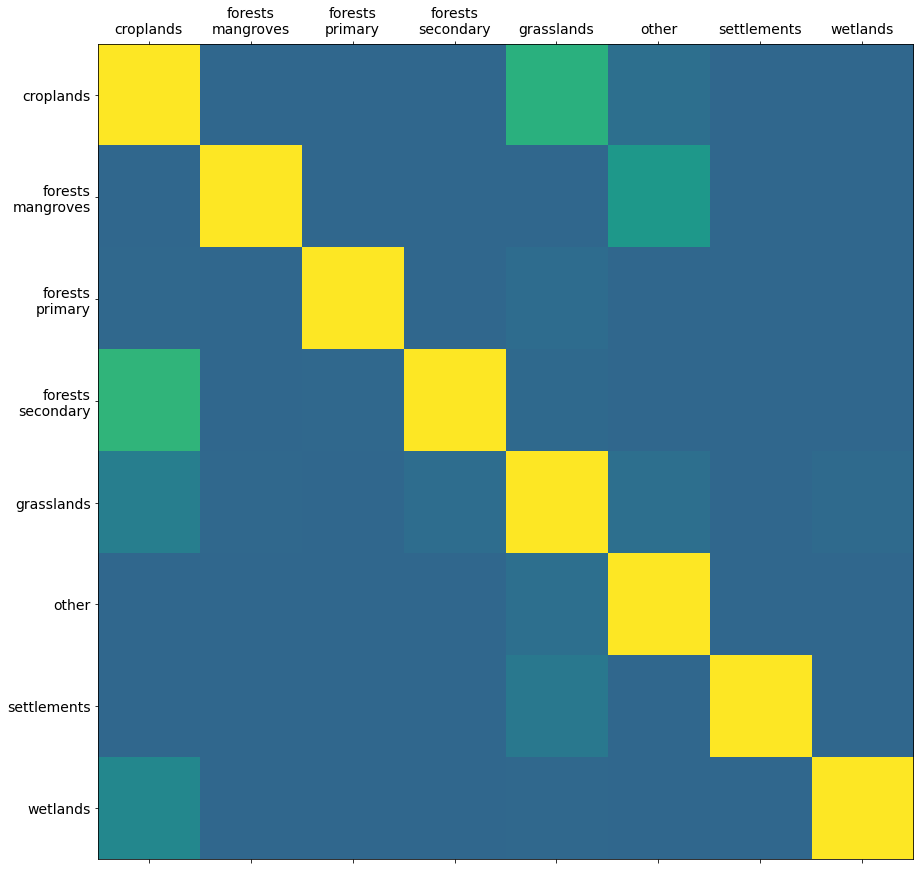

In [130]:
fig, ax = plt.subplots(figsize = (15, 15))
mat_plot = mat_min.copy()

s = mat_plot.shape
it = itertools.product(*[range(x) for x in s])
n = 10

labs = [x.replace("_", "\n") for x in sa.model_attributes.get_attribute_table("Land Use").key_values]
ax.set_xticks(np.array(range(s[0])))
ax.set_yticks(np.array(range(s[1])))

sz = 14
ax.set_xticklabels(labs, size = sz)
ax.set_yticklabels(labs, size = sz)

for i in enumerate(it):

    ind, (i, j) = i
    mat_plot[i, j] = max(min(mat_plot[i, j]*n, 1), 0)

ax.matshow(mat_plot, vmin = -0.5)
plt.savefig(os.path.join(sa.dir_out, "example_transition_matrix.jpg"))
